## Shortest Path Analysis with Machine Learning

In this code section, different ML models were trained using the graph-based metrics. For evaluation different classification metrics, as well as a uncertainy measure were performed. Finally, a completly random classifier was built to further investigate the performance of each classifier.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Analysis of ML dataset

A few analysis were computed to see the distribution of classes and the correlation of features.

Mean Distance: 4.91
Value Counts: distance
1         106
2        5614
3      172110
4      980516
5     1052684
6      481357
7      165364
8       51657
9       16080
10       4582
11       1563
12        401
13        108
14         16
15         16
Name: count, dtype: int64


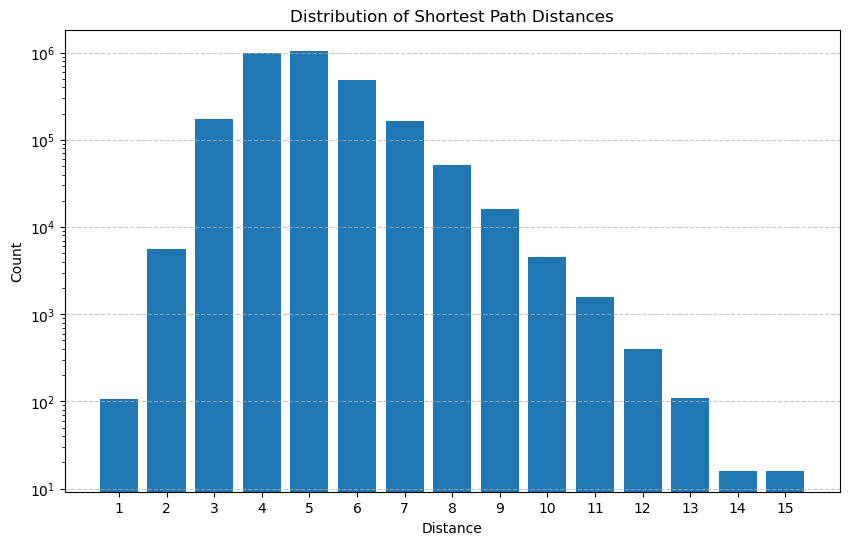

In [2]:
# Load the ML dataframe
shortest_path_df = pd.read_csv("data/shortest_path_df.csv")

# Print mean distance
print(f"Mean Distance: {shortest_path_df['distance'].mean():.2f}")

# Get value counts of distances
value_counts = shortest_path_df["distance"].value_counts().sort_index()

print("Value Counts:", value_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Shortest Path Distances")
plt.xticks(value_counts.index)
plt.yscale("log")  # Log scale for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Mean Distance: 4.90
Value Counts: distance
3     172110
4     980516
5    1052684
6     481357
7     165364
8      51657
9      16080
Name: count, dtype: int64


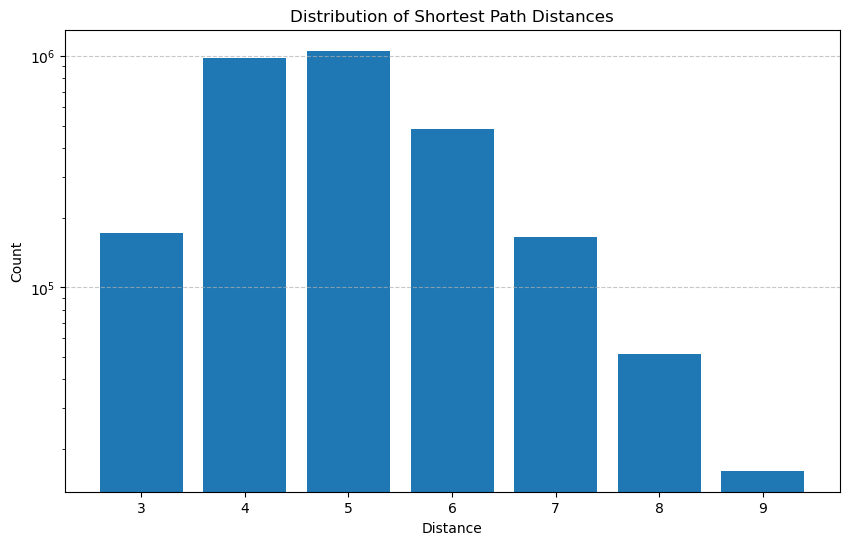

In [ ]:
# Filter the paths lengths between 3 and 9
reduced_df = shortest_path_df[(shortest_path_df["distance"] >= 3) & (shortest_path_df["distance"] <= 9)]

# Print mean distance
print(f"Mean Distance: {reduced_df['distance'].mean():.2f}")

# Get value counts of distances
value_counts = reduced_df["distance"].value_counts().sort_index()

print("Value Counts:", value_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Shortest Path Distances")
plt.xticks(value_counts.index)
plt.yscale("log")  # Log scale for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Define Features and Target
X = reduced_df[["pagerank_source", "in_degree_source", 
                      "out_degree_source", "hub_score_source", "authority_score_source", "eigenvector_centrality", "betweenness_centrality"]]
y = reduced_df["distance"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Necessary for MLP and XGBoost
y_train_adjusted = np.array(y_train) - np.min(y_train)
y_test_adjusted = np.array(y_test) - np.min(y_train)

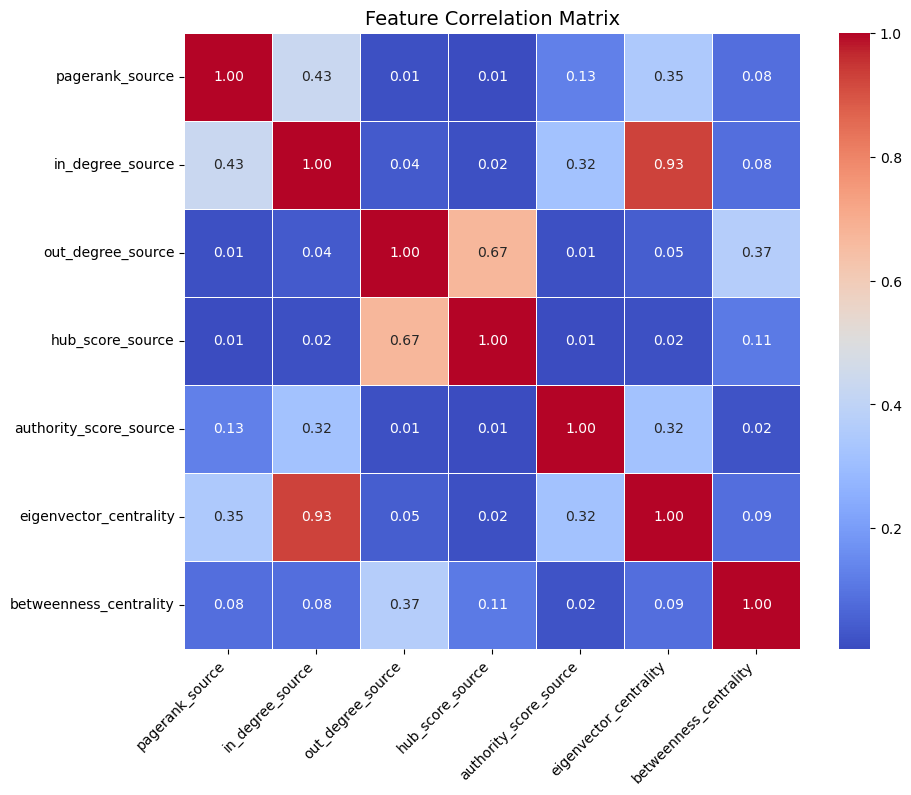

In [ ]:
# Calculating the correlation matrix
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)

# Titles and labels
plt.title("Feature Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()

# KNN Classifier

Best k: 10

KNN Classification Report:
              precision    recall  f1-score   support

           3       0.59      0.32      0.41     34324
           4       0.58      0.64      0.61    195938
           5       0.47      0.61      0.53    210352
           6       0.37      0.25      0.30     96651
           7       0.38      0.10      0.16     33238
           8       0.49      0.07      0.13     10255
           9       0.51      0.06      0.11      3196

    accuracy                           0.50    583954
   macro avg       0.48      0.29      0.32    583954
weighted avg       0.49      0.50      0.48    583954



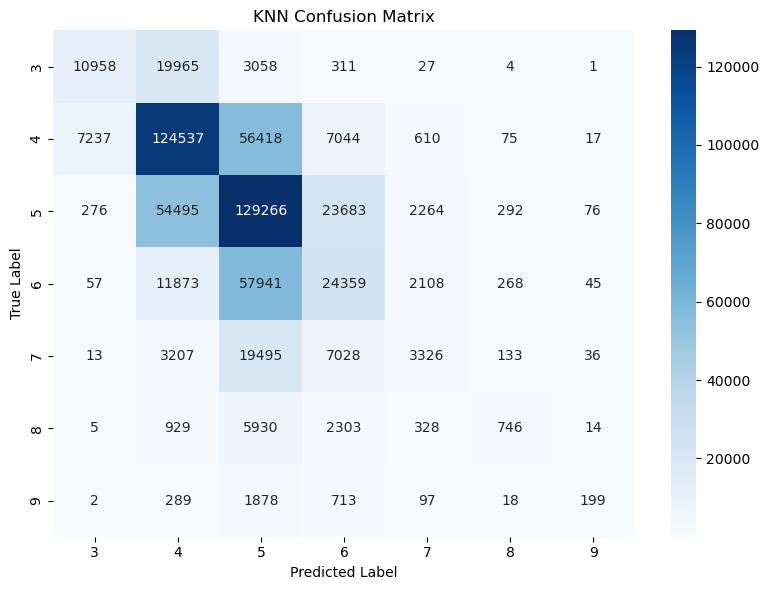

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
    cv=10,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Get best k
best_k = grid_search.best_params_["n_neighbors"]

# Display the best k value and its score
print(f"Best k: {best_k}")

# Use the best k to make predictions on the test set
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

# Evaluate the model
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

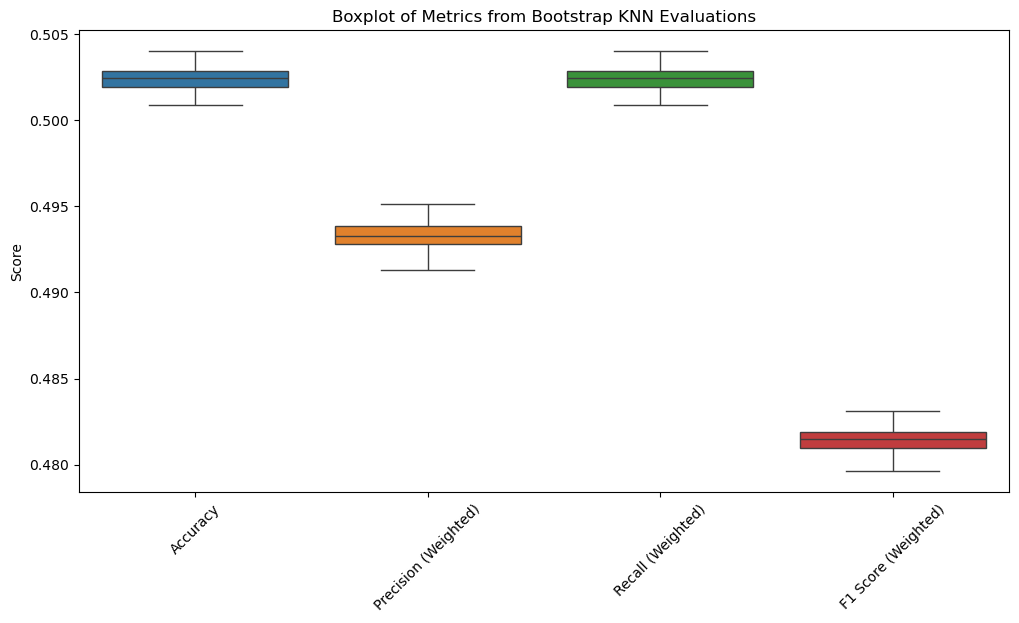

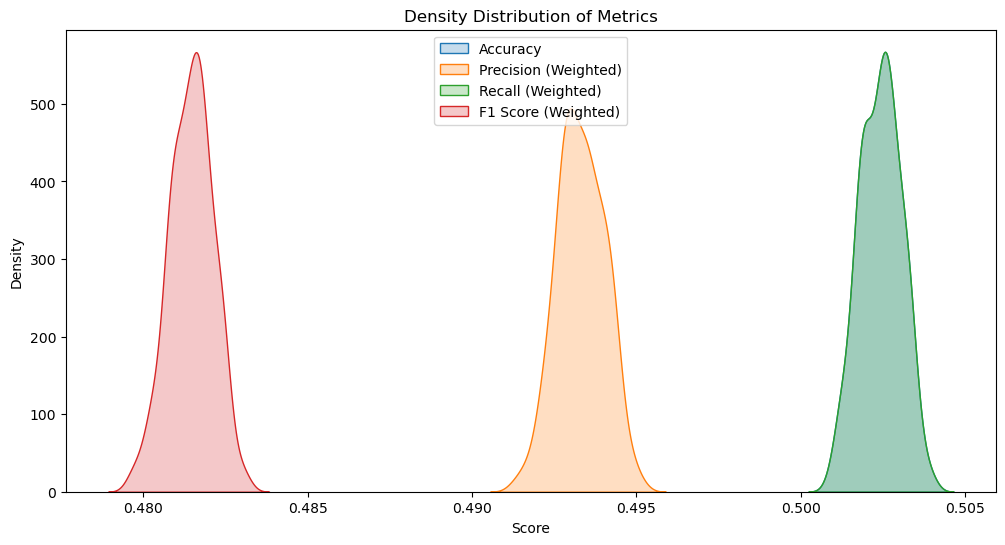

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Initialize list to store metrics for each bootstrap iteration
bootstrap_metrics = []

# Perform bootstrapping and train KNN models
n_bootstraps = 200
for _ in range(n_bootstraps):
    # Create a bootstrap sample from the test set (with replacement)
    X_test_bootstrap, y_test_bootstrap = resample(X_test_scaled, y_test, replace=True)

    # Predict with the best KNN model
    y_pred_knn = best_knn.predict(X_test_bootstrap)

    # Calculate metrics on the resampled test set
    accuracy = accuracy_score(y_test_bootstrap, y_pred_knn)
    precision_weighted = precision_score(y_test_bootstrap, y_pred_knn, average="weighted")
    recall_weighted = recall_score(y_test_bootstrap, y_pred_knn, average="weighted")
    f1_weighted = f1_score(y_test_bootstrap, y_pred_knn, average="weighted")

    # Append metrics to the list
    bootstrap_metrics.append({
        "Accuracy": accuracy,
        "Precision (Weighted)": precision_weighted,
        "Recall (Weighted)": recall_weighted,
        "F1 Score (Weighted)": f1_weighted
    })

# Convert the list of metrics into a DataFrame
bootstrap_metrics_df = pd.DataFrame(bootstrap_metrics)

# Boxplot for metrics
plt.figure(figsize=(12, 6))
sns.boxplot(data=bootstrap_metrics_df)
plt.title("Boxplot of Metrics from Bootstrap KNN Evaluations")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Density plot for metrics
plt.figure(figsize=(12, 6))
for column in bootstrap_metrics_df.columns:
    sns.kdeplot(bootstrap_metrics_df[column], label=column, fill=True)
plt.title("Density Distribution of Metrics")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# XGBoost Classifier


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.26      0.38     34324
           1       0.66      0.64      0.65    195938
           2       0.46      0.80      0.58    210352
           3       0.41      0.07      0.11     96651
           4       0.51      0.00      0.00     33238
           5       1.00      0.00      0.00     10255
           6       0.44      0.00      0.00      3196

    accuracy                           0.53    583954
   macro avg       0.60      0.25      0.25    583954
weighted avg       0.55      0.53      0.47    583954



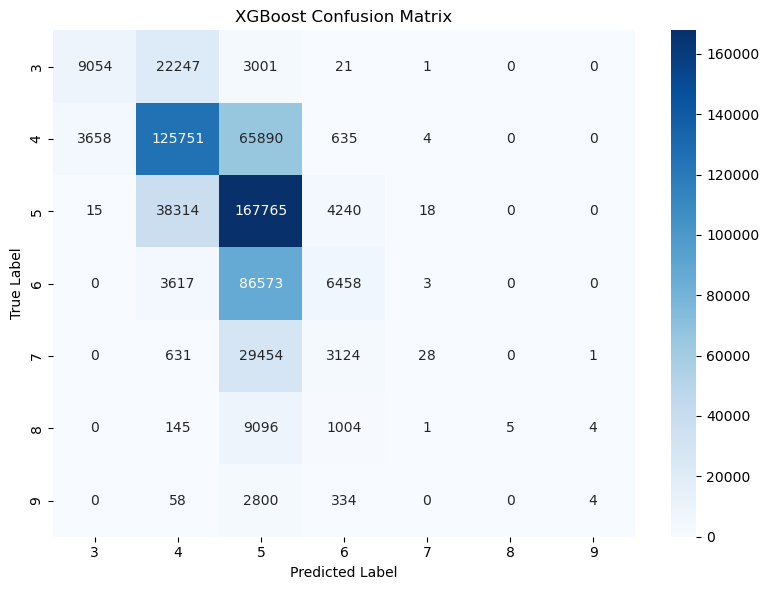

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Manually set hyperparameters
xgb = xgb.XGBClassifier(
    n_estimators=500,        # Number of boosting rounds
    learning_rate=0.01,      # Step size shrinkage
    max_depth=6,             # Maximum depth of each tree
    min_child_weight=3,      # Minimum sum of weights in a child node
    gamma=0.2,               # Minimum loss reduction for further partitioning
    reg_lambda=0.1,          # L2 regularization (shrinkage)
    eval_metric="mlogloss"   # Multi-class log loss as evaluation metric
)

# Train the model on the training data
xgb.fit(X_train_scaled, y_train_adjusted)

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate model
print("\nXGBoost Classification Report:")
print(classification_report(y_test_adjusted, y_pred_xgb))

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_adjusted, y_pred_xgb)

# Corrected labels mapping, necessary for the confusion matrix plot
corrected_labels = ["3", "4", "5", "6", "7", "8", "9"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=corrected_labels, yticklabels=corrected_labels)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

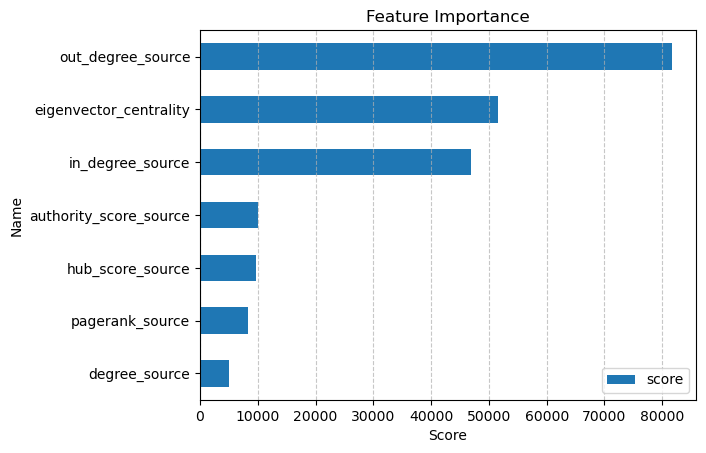

                          score
out_degree_source       81756.0
eigenvector_centrality  51623.0
in_degree_source        46858.0
authority_score_source  10065.0
hub_score_source         9681.0
pagerank_source          8355.0
degree_source            5051.0


In [19]:
# Assuming df is your dataset containing features
df_features = shortest_path_df.drop(columns=["source", "distance"])

# Get feature importance
feature_importance = xgb.get_booster().get_score(importance_type="weight")

# Map feature index to actual feature names
feature_names = df_features.columns.tolist()
feature_importance_mapped = {feature_names[int(key[1:])]: feature_importance.get(key, 0) for key in feature_importance.keys()}

# Convert to DataFrame and sort
feature_df = pd.DataFrame.from_dict(feature_importance_mapped, orient="index", columns=["score"])
feature_df = feature_df.sort_values(by="score", ascending=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_df.plot(kind="barh")
plt.xlabel("Score")
plt.ylabel("Name")
plt.title("Feature Importance")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Print feature names with importance values
print(feature_df.sort_values(by="score", ascending=False))

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Initialize list to store metrics for each bootstrap iteration
bootstrap_metrics = []

# Number of bootstrap samples
n_bootstraps = 200

for _ in range(n_bootstraps):
    # Create a bootstrap sample from the test set (with replacement)
    X_test_bootstrap, y_test_bootstrap = resample(X_test_scaled, y_test, replace=True)

    # Predict with the best XGBoost model
    y_pred_xgb = xgb.predict(X_test_bootstrap)

    # Calculate metrics on the resampled test set
    accuracy = accuracy_score(y_test_bootstrap, y_pred_xgb)
    precision_weighted = precision_score(y_test_bootstrap, y_pred_xgb, average="weighted")
    recall_weighted = recall_score(y_test_bootstrap, y_pred_xgb, average="weighted")
    f1_weighted = f1_score(y_test_bootstrap, y_pred_xgb, average="weighted")

    # Append metrics to the list
    bootstrap_metrics.append({
        "Accuracy": accuracy,
        "Precision (Weighted)": precision_weighted,
        "Recall (Weighted)": recall_weighted,
        "F1 (Weighted)": f1_weighted
    })

# Convert the list of metrics into a DataFrame
bootstrap_metrics_df = pd.DataFrame(bootstrap_metrics)

c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklea

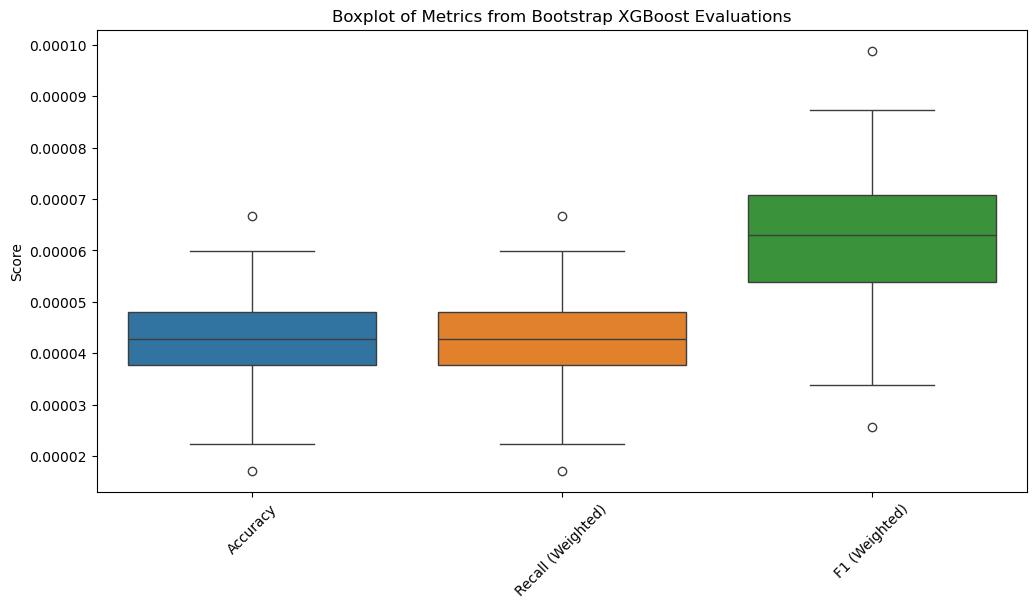

         Accuracy  Recall (Weighted)  F1 (Weighted)
count  200.000000         200.000000     200.000000
mean     0.000043           0.000043       0.000063
std      0.000008           0.000008       0.000012
min      0.000017           0.000017       0.000026
25%      0.000038           0.000038       0.000054
50%      0.000043           0.000043       0.000063
75%      0.000048           0.000048       0.000071
max      0.000067           0.000067       0.000099


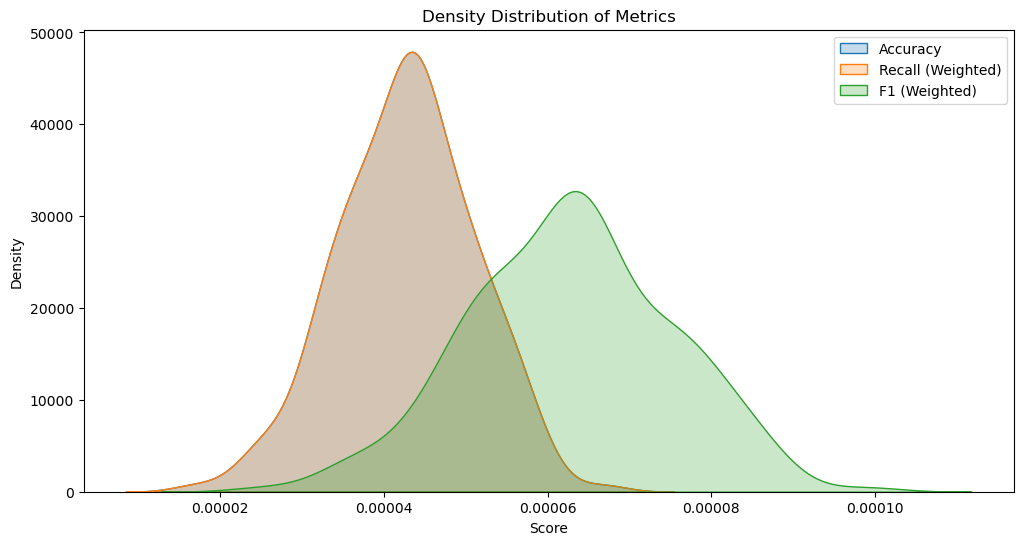

In [ ]:
# Remove precision from data
bootstrap_metrics_df_op = bootstrap_metrics_df.drop(columns=["Precision (Weighted)"])

# Boxplot for metrics without precision
plt.figure(figsize=(12, 6))
sns.boxplot(data=bootstrap_metrics_df_op)
plt.title("Boxplot of Metrics from Bootstrap XGBoost Evaluations")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Summary statistics for metrics without precision
print(bootstrap_metrics_df_op.describe())

# Density plot for metrics without precision
plt.figure(figsize=(12, 6))
for column in bootstrap_metrics_df_op.columns:
    sns.kdeplot(bootstrap_metrics_df_op[column], label=column, fill=True)
plt.title("Density Distribution of Metrics")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

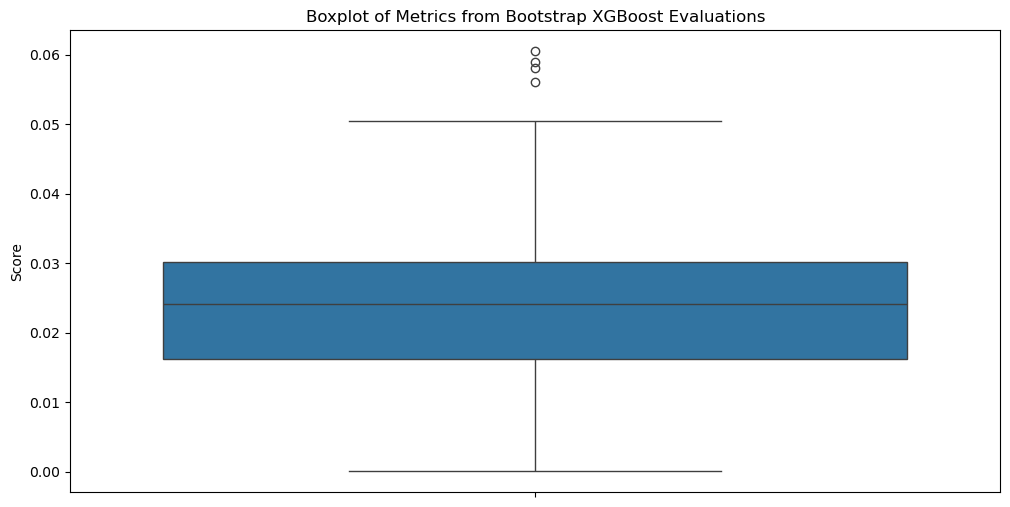

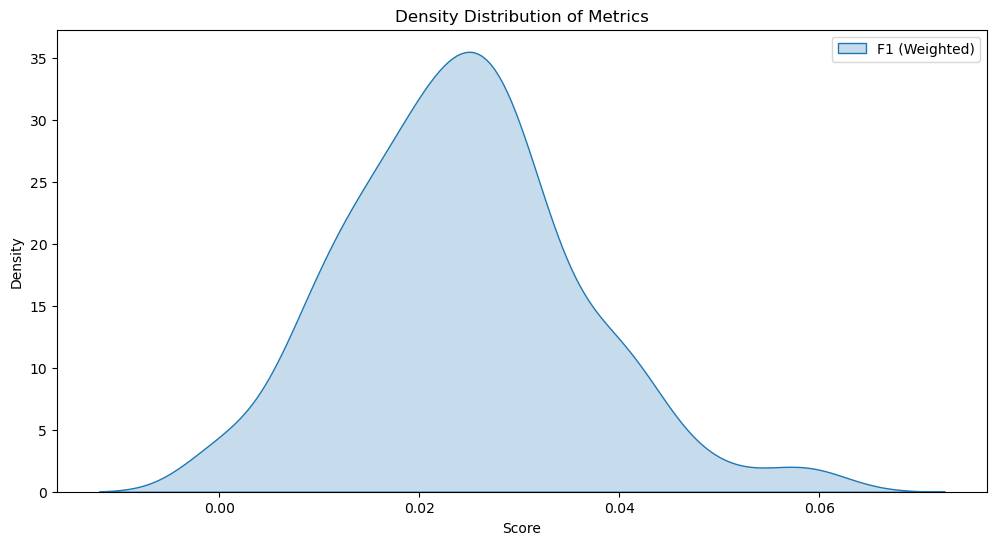

In [ ]:
# Boxplot for precision
plt.figure(figsize=(12, 6))
sns.boxplot(data=bootstrap_metrics_df["Precision (Weighted)"])
plt.title("Boxplot of Metrics from Bootstrap XGBoost Evaluations")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Density plot for precision
plt.figure(figsize=(12, 6))
sns.kdeplot(bootstrap_metrics_df["Precision (Weighted)"], fill=True)
plt.title("Density Distribution of Metrics")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# MLP Classifier

Iteration 1, loss = 1.18407475
Validation score: 0.509854
Iteration 2, loss = 1.16237850
Validation score: 0.520065
Iteration 3, loss = 1.16020832
Validation score: 0.520608
Iteration 4, loss = 1.15735268
Validation score: 0.521617
Iteration 5, loss = 1.15106434
Validation score: 0.523997
Iteration 6, loss = 1.14516801
Validation score: 0.525168
Iteration 7, loss = 1.14228166
Validation score: 0.525384
Iteration 8, loss = 1.14051869
Validation score: 0.525003
Iteration 9, loss = 1.13960784
Validation score: 0.524988
Iteration 10, loss = 1.13882031
Validation score: 0.525819
Iteration 11, loss = 1.13796068
Validation score: 0.525382
Iteration 12, loss = 1.13731970
Validation score: 0.523049
Iteration 13, loss = 1.13710455
Validation score: 0.525947
Iteration 14, loss = 1.13636894
Validation score: 0.525831
Iteration 15, loss = 1.13614964
Validation score: 0.526031
Iteration 16, loss = 1.13581718
Validation score: 0.524847
Iteration 17, loss = 1.13542621
Validation score: 0.525988
Iterat

c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.70      0.28      0.40     34324
           1       0.66      0.64      0.65    195938
           2       0.46      0.80      0.58    210352
           3       0.38      0.05      0.08     96651
           4       0.00      0.00      0.00     33238
           5       0.00      0.00      0.00     10255
           6       0.00      0.00      0.00      3196

    accuracy                           0.53    583954
   macro avg       0.31      0.25      0.24    583954
weighted avg       0.49      0.53      0.46    583954



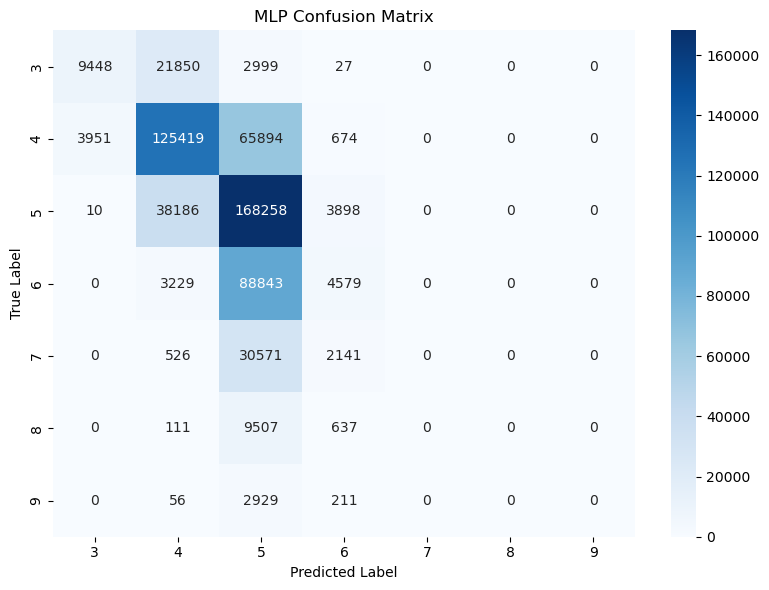

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Create MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64, 32), # Number of neurons in each hidden layer
    activation="relu",                          # Activation function used in hidden layers
    solver="adam",                              # Optimizer for training the network
    alpha=0.001,                                # Regularization strength (helps prevent overfitting)
    learning_rate="adaptive",                   # Adjusts learning rate based on training progress
    learning_rate_init=0.0001,                  # Starting learning rate
    max_iter=100,                               # Maximum number of training cycles (epochs)
    early_stopping=True,                        # Stops training early if validation score doesn’t improve
    validation_fraction=0.2,                    # 20% of training data used for validation
    n_iter_no_change=10,                        # Stops training if no improvement for 10 iterations
    verbose=True                                # Prints progress messages while training
)

# Train the model using the training data
mlp.fit(X_train_scaled, y_train_adjusted)

# Make predictions
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate model
print("\nMLP Classification Report:")
print(classification_report(y_test_adjusted, y_pred_mlp))

# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test_adjusted, y_pred_mlp)

# Corrected labels mapping
corrected_labels = ["3", "4", "5", "6", "7", "8", "9"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=corrected_labels, yticklabels=corrected_labels)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\anaconda3\Lib\site-packages\sklea

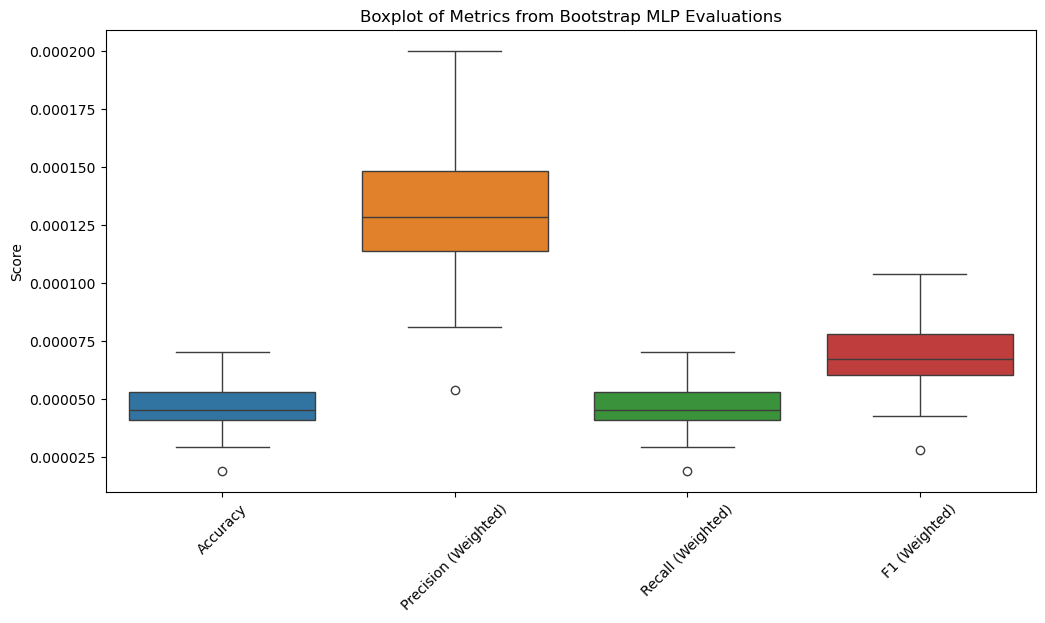

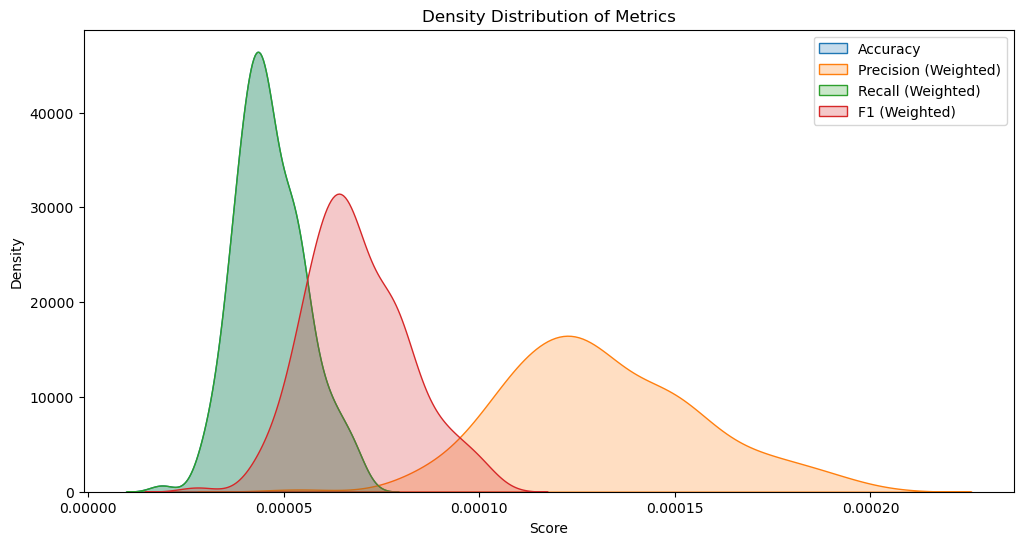

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Initialize list to store metrics for each bootstrap iteration
bootstrap_metrics = []

# Number of bootstrap samples
# 200 in 120 min
n_bootstraps = 200

for _ in range(n_bootstraps):
    # Create a bootstrap sample from the test set (with replacement)
    X_test_bootstrap, y_test_bootstrap = resample(X_test_scaled, y_test, replace=True)

    # Predict with the best MLP model
    y_pred_mlp = mlp.predict(X_test_bootstrap)

    # Calculate metrics on the resampled test set
    accuracy = accuracy_score(y_test_bootstrap, y_pred_mlp)
    precision_weighted = precision_score(y_test_bootstrap, y_pred_mlp, average="weighted")
    recall_weighted = recall_score(y_test_bootstrap, y_pred_mlp, average="weighted")
    f1_weighted = f1_score(y_test_bootstrap, y_pred_mlp, average="weighted")

    # Append metrics to the list
    bootstrap_metrics.append({
        "Accuracy": accuracy,
        "Precision (Weighted)": precision_weighted,
        "Recall (Weighted)": recall_weighted,
        "F1 (Weighted)": f1_weighted
    })

# Convert the list of metrics into a DataFrame
bootstrap_metrics_df = pd.DataFrame(bootstrap_metrics)

# Boxplot for metrics
plt.figure(figsize=(12, 6))
sns.boxplot(data=bootstrap_metrics_df)
plt.title("Boxplot of Metrics from Bootstrap MLP Evaluations")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Density plot for metrics
plt.figure(figsize=(12, 6))
for column in bootstrap_metrics_df.columns:
    sns.kdeplot(bootstrap_metrics_df[column], label=column, fill=True)
plt.title("Density Distribution of Metrics")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

MLP hat die Parameter True Label komplett unterschätzt. Entweder wurden Label 3-7 korrekt predicted oder nicht.
Die Streuung ist sehr gering und unterepräsentierte Klassen wurden extrem schlecht vorhergesagt.

# Random Classifier

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

# Get the value counts of distances
value_counts = reduced_df["distance"].value_counts().sort_index()

# Calculate probabilities
total_count = value_counts.sum()
classes = value_counts.index.tolist()
probabilities = (value_counts / total_count).tolist()

# Random Classifier
y_true = np.random.choice(classes, size=100000, p=probabilities)
y_pred = np.random.choice(classes, size=100000, p=probabilities)

# Evaluate Random Classifier
accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average="weighted")
recall_weighted = recall_score(y_true, y_pred, average="weighted")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

# Print metrics for random classifier
print("Random Classifier Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

Random Classifier Evaluation:
Accuracy: 0.2747
Precision (Weighted): 0.2742
Recall (Weighted): 0.2747
F1 Score (Weighted): 0.2744
